# Protocol Selection of FedLeak (CenterCrop Generator), ImageNet(ISLVRC2012).

Here is the protocol selection to decide in which way should FedLeak be transferred.

We evaluate it with ***ImageNet(ISLVRC2012)***, with $5$ times sampling batch = $16$, reporting the best results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from test-set, with `shuffle=False`.
- *Way to report*: best PSNRs in $5$ times recovery.

Codes are aligned with `sanity_check_center_crop_ImageNet.ipynb`, with two modifications utilized:
- ⭕ Force generating with $224\times224\times3$.
- ⭕ Abort comparing with `upsampling` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:0")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224))
])

dataset = torchvision.datasets.ImageNet(root="~/data/imagenet/", split="val", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, generator=torch.Generator().manual_seed(seed))
loader_iter = iter(trainloader)

device

device(type='cuda', index=0)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

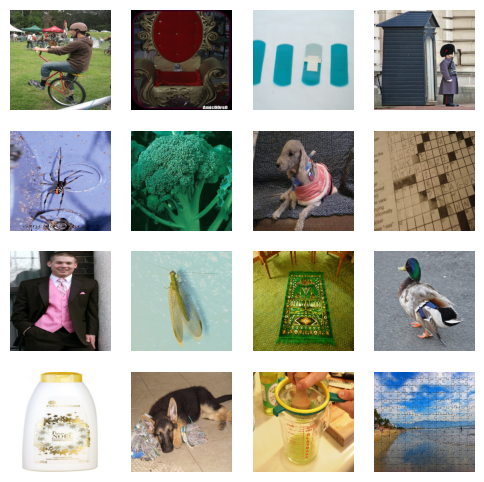

| It: 1 | Loss: -9.1949 | Time:   4.90s |


| It: 1001 | Loss: -60.2045 | Time: 361.72s |


| It: 2001 | Loss: -61.1335 | Time: 466.08s |


| It: 3001 | Loss: -61.4360 | Time: 472.82s |


| It: 4001 | Loss: -61.5826 | Time: 474.18s |


| It: 5001 | Loss: -61.6784 | Time: 471.94s |


| It: 6001 | Loss: -61.7374 | Time: 473.51s |


| It: 7001 | Loss: -61.7840 | Time: 472.01s |


| It: 8001 | Loss: -61.8139 | Time: 471.95s |


| It: 9001 | Loss: -61.8279 | Time: 471.32s |


| It: 1 | Loss: -4.0517 | Time:   0.47s |


| It: 1001 | Loss: -60.1812 | Time: 468.52s |


| It: 2001 | Loss: -61.0660 | Time: 473.96s |


| It: 3001 | Loss: -61.4274 | Time: 472.75s |


| It: 4001 | Loss: -61.5914 | Time: 473.25s |


| It: 5001 | Loss: -61.6824 | Time: 472.23s |


| It: 6001 | Loss: -61.7476 | Time: 472.11s |


| It: 7001 | Loss: -61.7907 | Time: 472.79s |


| It: 8001 | Loss: -61.8197 | Time: 474.74s |


| It: 9001 | Loss: -61.8333 | Time: 473.61s |


| It: 1 | Loss: 1.2634 | Time:   0.50s |


| It: 1001 | Loss: -60.6770 | Time: 470.49s |


| It: 2001 | Loss: -61.3548 | Time: 471.47s |


| It: 3001 | Loss: -61.5682 | Time: 472.14s |


| It: 4001 | Loss: -61.6688 | Time: 472.53s |


| It: 5001 | Loss: -61.7306 | Time: 473.13s |


| It: 6001 | Loss: -61.7813 | Time: 470.31s |


| It: 7001 | Loss: -61.8181 | Time: 473.12s |


| It: 8001 | Loss: -61.8400 | Time: 473.03s |


| It: 9001 | Loss: -61.8508 | Time: 472.91s |


| It: 1 | Loss: -7.3243 | Time:   0.50s |


| It: 1001 | Loss: -60.2784 | Time: 472.66s |


| It: 2001 | Loss: -61.0774 | Time: 473.77s |


| It: 3001 | Loss: -61.4246 | Time: 473.30s |


| It: 4001 | Loss: -61.5595 | Time: 469.23s |


| It: 5001 | Loss: -61.6643 | Time: 472.50s |


| It: 6001 | Loss: -61.7409 | Time: 470.68s |


| It: 7001 | Loss: -61.7875 | Time: 473.35s |


| It: 8001 | Loss: -61.8152 | Time: 472.12s |


| It: 9001 | Loss: -61.8287 | Time: 474.22s |


| It: 1 | Loss: -5.4662 | Time:   0.47s |


| It: 1001 | Loss: -60.1540 | Time: 471.73s |


| It: 2001 | Loss: -61.0411 | Time: 470.80s |


| It: 3001 | Loss: -61.3856 | Time: 472.04s |


| It: 4001 | Loss: -61.5574 | Time: 473.49s |


| It: 5001 | Loss: -61.6725 | Time: 472.57s |


| It: 6001 | Loss: -61.7286 | Time: 472.67s |


| It: 7001 | Loss: -61.7773 | Time: 470.25s |


| It: 8001 | Loss: -61.8060 | Time: 471.04s |


| It: 9001 | Loss: -61.8215 | Time: 472.27s |


BEST PSNR: 15.7702
MEDIAN PSNR: 14.9370
ALL PSNR: [14.0065, 14.9334, 15.3897, 15.7702, 15.7702]


<Figure size 400x300 with 0 Axes>

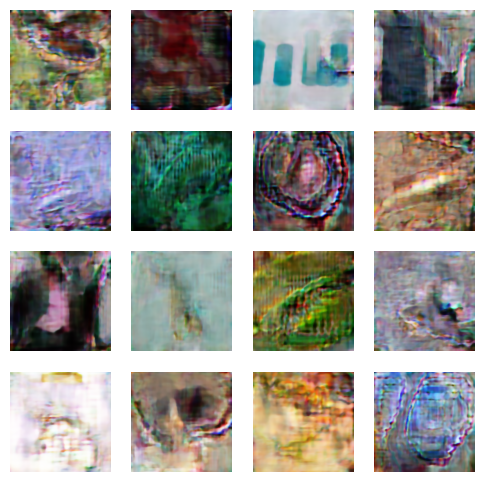

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

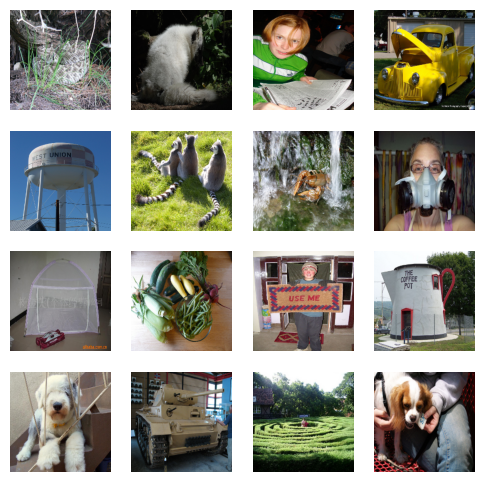

| It: 1 | Loss: -11.4614 | Time:   0.45s |


| It: 1001 | Loss: -59.0881 | Time: 470.11s |


| It: 2001 | Loss: -60.6489 | Time: 376.01s |


| It: 3001 | Loss: -61.0537 | Time: 363.14s |


| It: 4001 | Loss: -61.3323 | Time: 361.10s |


| It: 5001 | Loss: -61.4701 | Time: 364.11s |


| It: 6001 | Loss: -61.5714 | Time: 365.36s |


| It: 7001 | Loss: -61.6375 | Time: 363.42s |


| It: 8001 | Loss: -61.6838 | Time: 364.27s |


| It: 9001 | Loss: -61.7054 | Time: 361.97s |


| It: 1 | Loss: -5.5327 | Time:   0.36s |


| It: 1001 | Loss: -58.7714 | Time: 360.15s |


| It: 2001 | Loss: -60.3401 | Time: 364.72s |


| It: 3001 | Loss: -60.9159 | Time: 364.52s |


| It: 4001 | Loss: -61.1835 | Time: 362.04s |


| It: 5001 | Loss: -61.3737 | Time: 362.44s |


| It: 6001 | Loss: -61.4931 | Time: 363.72s |


| It: 7001 | Loss: -61.5782 | Time: 363.53s |


| It: 8001 | Loss: -61.6352 | Time: 363.30s |


| It: 9001 | Loss: -61.6612 | Time: 363.97s |


| It: 1 | Loss: -13.4814 | Time:   0.37s |


| It: 1001 | Loss: -58.8103 | Time: 363.07s |


| It: 2001 | Loss: -60.2475 | Time: 362.82s |


| It: 3001 | Loss: -60.8725 | Time: 363.01s |


| It: 4001 | Loss: -61.1846 | Time: 364.56s |


| It: 5001 | Loss: -61.3520 | Time: 362.38s |


| It: 6001 | Loss: -61.4861 | Time: 363.76s |


| It: 7001 | Loss: -61.5725 | Time: 363.52s |


| It: 8001 | Loss: -61.6255 | Time: 364.21s |


| It: 9001 | Loss: -61.6523 | Time: 360.86s |


| It: 1 | Loss: -7.8180 | Time:   0.37s |


| It: 1001 | Loss: -58.8237 | Time: 360.40s |


| It: 2001 | Loss: -60.4333 | Time: 362.58s |


| It: 3001 | Loss: -60.9882 | Time: 358.50s |


| It: 4001 | Loss: -61.2464 | Time: 364.16s |


| It: 5001 | Loss: -61.4248 | Time: 363.60s |


| It: 6001 | Loss: -61.5265 | Time: 364.34s |


| It: 7001 | Loss: -61.5992 | Time: 361.42s |


| It: 8001 | Loss: -61.6500 | Time: 363.57s |


| It: 9001 | Loss: -61.6750 | Time: 364.14s |


| It: 1 | Loss: -8.5501 | Time:   0.39s |


| It: 1001 | Loss: -59.3941 | Time: 363.20s |


| It: 2001 | Loss: -60.7042 | Time: 361.44s |


| It: 3001 | Loss: -61.1828 | Time: 362.76s |


| It: 4001 | Loss: -61.3638 | Time: 363.75s |


| It: 5001 | Loss: -61.4995 | Time: 357.10s |


| It: 6001 | Loss: -61.5942 | Time: 363.62s |


| It: 7001 | Loss: -61.6590 | Time: 359.59s |


| It: 8001 | Loss: -61.6966 | Time: 362.73s |


| It: 9001 | Loss: -61.7228 | Time: 364.34s |


BEST PSNR: 13.8989
MEDIAN PSNR: 13.6182
ALL PSNR: [13.8637, 13.2022, 13.7217, 13.4043, 13.4043]


<Figure size 400x300 with 0 Axes>

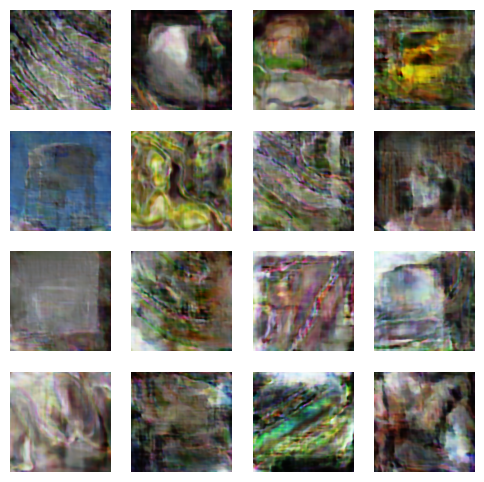

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

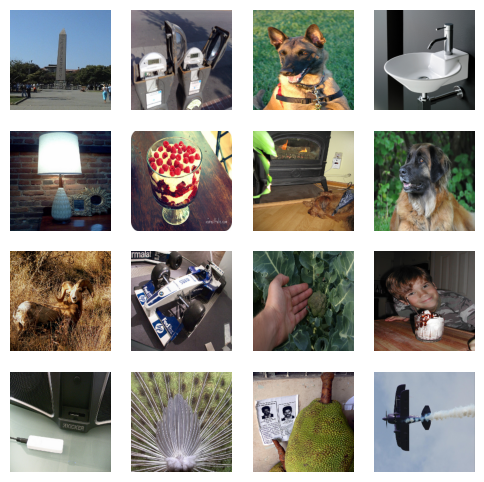

| It: 1 | Loss: -6.9161 | Time:   0.36s |


| It: 1001 | Loss: -59.5916 | Time: 363.43s |


| It: 2001 | Loss: -60.8502 | Time: 362.94s |


| It: 3001 | Loss: -61.2715 | Time: 365.66s |


| It: 4001 | Loss: -61.4720 | Time: 362.78s |


| It: 5001 | Loss: -61.5777 | Time: 363.49s |


| It: 6001 | Loss: -61.6587 | Time: 361.72s |


| It: 7001 | Loss: -61.7162 | Time: 363.70s |


| It: 8001 | Loss: -61.7527 | Time: 361.94s |


| It: 9001 | Loss: -61.7714 | Time: 364.60s |


| It: 1 | Loss: -0.4603 | Time:   0.36s |


| It: 1001 | Loss: -59.6806 | Time: 364.12s |


| It: 2001 | Loss: -60.8022 | Time: 362.02s |


| It: 3001 | Loss: -61.2394 | Time: 363.94s |


| It: 4001 | Loss: -61.4542 | Time: 362.97s |


| It: 5001 | Loss: -61.5752 | Time: 363.05s |


| It: 6001 | Loss: -61.6505 | Time: 363.40s |


| It: 7001 | Loss: -61.7090 | Time: 363.34s |


| It: 8001 | Loss: -61.7471 | Time: 363.61s |


| It: 9001 | Loss: -61.7661 | Time: 364.13s |


| It: 1 | Loss: -7.3933 | Time:   0.37s |


| It: 1001 | Loss: -60.0401 | Time: 363.14s |


| It: 2001 | Loss: -60.9918 | Time: 363.13s |


| It: 3001 | Loss: -61.3074 | Time: 363.15s |


| It: 4001 | Loss: -61.4932 | Time: 363.87s |


| It: 5001 | Loss: -61.5929 | Time: 365.09s |


| It: 6001 | Loss: -61.6594 | Time: 363.98s |


| It: 7001 | Loss: -61.7190 | Time: 363.63s |


| It: 8001 | Loss: -61.7547 | Time: 363.58s |


| It: 9001 | Loss: -61.7712 | Time: 364.50s |


| It: 1 | Loss: -9.3758 | Time:   0.36s |


| It: 1001 | Loss: -59.8697 | Time: 364.79s |


| It: 2001 | Loss: -60.9466 | Time: 364.83s |


| It: 3001 | Loss: -61.3080 | Time: 364.21s |


| It: 4001 | Loss: -61.4697 | Time: 363.39s |


| It: 5001 | Loss: -61.5878 | Time: 364.02s |


| It: 6001 | Loss: -61.6581 | Time: 363.86s |


| It: 7001 | Loss: -61.7187 | Time: 364.08s |


| It: 8001 | Loss: -61.7529 | Time: 364.23s |


| It: 9001 | Loss: -61.7695 | Time: 364.84s |


| It: 1 | Loss: -11.8870 | Time:   0.36s |


| It: 1001 | Loss: -60.0696 | Time: 361.18s |


| It: 2001 | Loss: -61.0519 | Time: 364.75s |


| It: 3001 | Loss: -61.3794 | Time: 363.26s |


| It: 4001 | Loss: -61.5249 | Time: 361.64s |


| It: 5001 | Loss: -61.6160 | Time: 362.32s |


| It: 6001 | Loss: -61.6933 | Time: 364.65s |


| It: 7001 | Loss: -61.7405 | Time: 363.57s |


| It: 8001 | Loss: -61.7735 | Time: 364.60s |


| It: 9001 | Loss: -61.7892 | Time: 364.48s |


BEST PSNR: 14.7635
MEDIAN PSNR: 14.4956
ALL PSNR: [13.8346, 14.7417, 14.6262, 14.7635, 14.7635]


<Figure size 400x300 with 0 Axes>

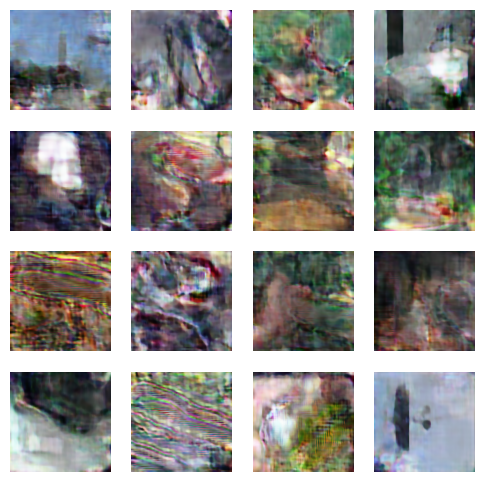

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

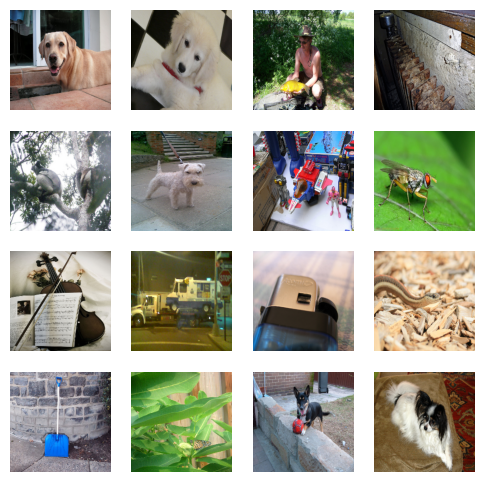

| It: 1 | Loss: -21.4904 | Time:   0.36s |


| It: 1001 | Loss: -60.2197 | Time: 361.58s |


| It: 2001 | Loss: -61.1355 | Time: 365.33s |


| It: 3001 | Loss: -61.4054 | Time: 363.00s |


| It: 4001 | Loss: -61.5483 | Time: 363.25s |


| It: 5001 | Loss: -61.6351 | Time: 363.84s |


| It: 6001 | Loss: -61.7000 | Time: 364.91s |


| It: 7001 | Loss: -61.7486 | Time: 364.49s |


| It: 8001 | Loss: -61.7780 | Time: 364.23s |


| It: 9001 | Loss: -61.7935 | Time: 365.20s |


| It: 1 | Loss: -11.9807 | Time:   0.33s |


| It: 1001 | Loss: -59.8883 | Time: 359.53s |


| It: 2001 | Loss: -61.0545 | Time: 365.49s |


| It: 3001 | Loss: -61.3859 | Time: 365.52s |


| It: 4001 | Loss: -61.5381 | Time: 366.26s |


| It: 5001 | Loss: -61.6272 | Time: 362.68s |


| It: 6001 | Loss: -61.6972 | Time: 366.96s |


| It: 7001 | Loss: -61.7442 | Time: 366.50s |


| It: 8001 | Loss: -61.7761 | Time: 366.53s |


| It: 9001 | Loss: -61.7925 | Time: 366.04s |


| It: 1 | Loss: -11.2364 | Time:   0.36s |


| It: 1001 | Loss: -59.6984 | Time: 366.45s |


| It: 2001 | Loss: -60.9226 | Time: 364.06s |


| It: 3001 | Loss: -61.3142 | Time: 367.28s |


| It: 4001 | Loss: -61.4630 | Time: 368.08s |


| It: 5001 | Loss: -61.5886 | Time: 369.65s |


| It: 6001 | Loss: -61.6686 | Time: 369.83s |


| It: 7001 | Loss: -61.7240 | Time: 367.96s |


| It: 8001 | Loss: -61.7605 | Time: 368.38s |


| It: 9001 | Loss: -61.7778 | Time: 368.87s |


| It: 1 | Loss: -5.0537 | Time:   0.51s |


| It: 1001 | Loss: -60.3630 | Time: 474.86s |


| It: 2001 | Loss: -61.1801 | Time: 472.09s |


| It: 3001 | Loss: -61.4452 | Time: 474.25s |


| It: 4001 | Loss: -61.5729 | Time: 473.45s |


| It: 5001 | Loss: -61.6548 | Time: 473.06s |


| It: 6001 | Loss: -61.7175 | Time: 473.31s |


| It: 7001 | Loss: -61.7613 | Time: 474.59s |


| It: 8001 | Loss: -61.7915 | Time: 474.70s |


| It: 9001 | Loss: -61.8057 | Time: 475.96s |


| It: 1 | Loss: -4.9467 | Time:   0.51s |


| It: 1001 | Loss: -60.0371 | Time: 474.48s |


| It: 2001 | Loss: -61.0525 | Time: 474.72s |


| It: 3001 | Loss: -61.3722 | Time: 475.29s |


| It: 4001 | Loss: -61.5058 | Time: 474.56s |


| It: 5001 | Loss: -61.6260 | Time: 474.21s |


| It: 6001 | Loss: -61.6902 | Time: 474.17s |


| It: 7001 | Loss: -61.7420 | Time: 474.06s |


| It: 8001 | Loss: -61.7766 | Time: 472.87s |


| It: 9001 | Loss: -61.7931 | Time: 472.67s |


BEST PSNR: 14.5753
MEDIAN PSNR: 14.3193
ALL PSNR: [14.3687, 14.2473, 14.5753, 14.4180, 14.4180]


<Figure size 400x300 with 0 Axes>

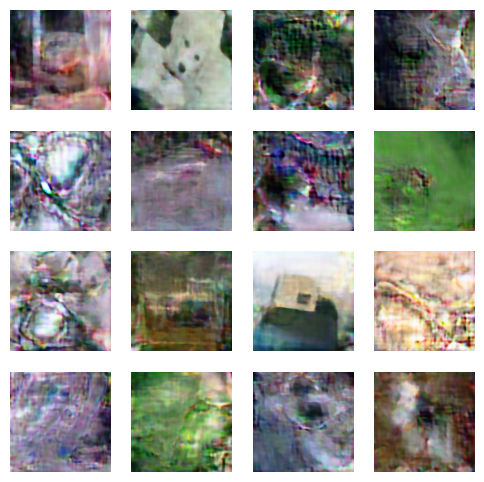

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

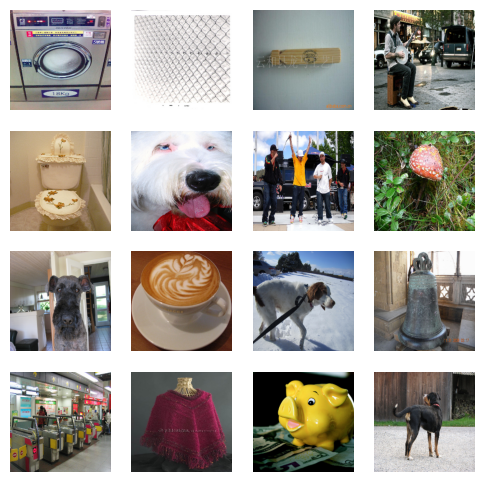

| It: 1 | Loss: -3.2586 | Time:   0.46s |


| It: 1001 | Loss: -60.3135 | Time: 474.48s |


| It: 2001 | Loss: -61.1429 | Time: 473.93s |


| It: 3001 | Loss: -61.4499 | Time: 473.21s |


| It: 4001 | Loss: -61.5892 | Time: 472.90s |


| It: 5001 | Loss: -61.6789 | Time: 474.00s |


| It: 6001 | Loss: -61.7452 | Time: 554.24s |


| It: 7001 | Loss: -61.7861 | Time: 571.86s |


| It: 8001 | Loss: -61.8137 | Time: 573.58s |


| It: 9001 | Loss: -61.8271 | Time: 572.80s |


| It: 1 | Loss: -12.2469 | Time:   0.57s |


| It: 1001 | Loss: -60.0678 | Time: 574.93s |


| It: 2001 | Loss: -60.9119 | Time: 575.01s |


| It: 3001 | Loss: -61.3217 | Time: 574.01s |


| It: 4001 | Loss: -61.5076 | Time: 574.78s |


| It: 5001 | Loss: -61.6109 | Time: 574.45s |


| It: 6001 | Loss: -61.6885 | Time: 575.47s |


| It: 7001 | Loss: -61.7427 | Time: 572.82s |


| It: 8001 | Loss: -61.7765 | Time: 573.24s |


| It: 9001 | Loss: -61.7924 | Time: 573.45s |


| It: 1 | Loss: -4.6637 | Time:   0.60s |


| It: 1001 | Loss: -60.0666 | Time: 573.39s |


| It: 2001 | Loss: -60.9517 | Time: 573.06s |


| It: 3001 | Loss: -61.2755 | Time: 575.10s |


| It: 4001 | Loss: -61.4650 | Time: 575.97s |


| It: 5001 | Loss: -61.5728 | Time: 575.35s |


| It: 6001 | Loss: -61.6593 | Time: 574.82s |


| It: 7001 | Loss: -61.7162 | Time: 575.02s |


| It: 8001 | Loss: -61.7518 | Time: 575.23s |


| It: 9001 | Loss: -61.7689 | Time: 574.47s |


| It: 1 | Loss: -5.2706 | Time:   0.56s |


| It: 1001 | Loss: -59.7950 | Time: 575.51s |


| It: 2001 | Loss: -60.8228 | Time: 574.42s |


| It: 3001 | Loss: -61.2189 | Time: 574.97s |


| It: 4001 | Loss: -61.4352 | Time: 571.44s |


| It: 5001 | Loss: -61.5635 | Time: 573.90s |


| It: 6001 | Loss: -61.6611 | Time: 571.49s |


| It: 7001 | Loss: -61.7207 | Time: 573.41s |


| It: 8001 | Loss: -61.7563 | Time: 575.11s |


| It: 9001 | Loss: -61.7732 | Time: 572.97s |


| It: 1 | Loss: -2.9174 | Time:   0.57s |


| It: 1001 | Loss: -59.6971 | Time: 573.98s |


| It: 2001 | Loss: -60.9526 | Time: 573.44s |


| It: 3001 | Loss: -61.3155 | Time: 574.82s |


| It: 4001 | Loss: -61.4988 | Time: 572.97s |


| It: 5001 | Loss: -61.6267 | Time: 574.34s |


| It: 6001 | Loss: -61.6930 | Time: 572.90s |


| It: 7001 | Loss: -61.7500 | Time: 571.45s |


| It: 8001 | Loss: -61.7802 | Time: 573.30s |


| It: 9001 | Loss: -61.7975 | Time: 572.17s |


BEST PSNR: 14.1776
MEDIAN PSNR: 13.2420
ALL PSNR: [12.5332, 12.3464, 14.0823, 13.0703, 13.0703]


<Figure size 400x300 with 0 Axes>

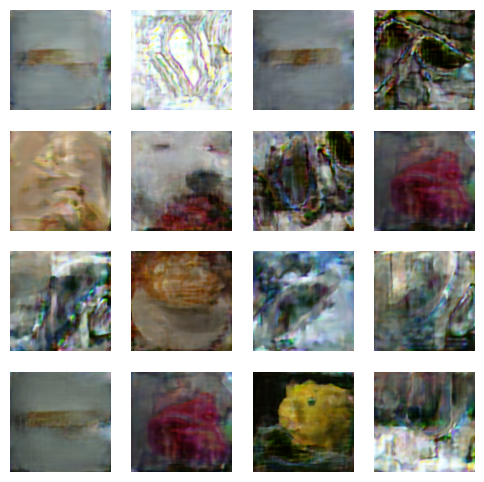

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, num_iters=10000, plot_interval=1000, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)